# Experiments


## Notes

* Prerequisites
    * `pip3 install torch == 1.2.0`
    * `pip3 install gym == 0.23.1`
    * `pip3 install mujoco == 2.2.1`
* For lunar lander    
    * `conda install swig`
    * `pip3 install box2d-py`
* if there's a`mujoco_py does not exist` error, on the `gym` and/or `d4rl` package, import `mujoco as mujoco_py`

* Pybullet datasets reference
    * https://github.com/takuseno/d4rl-pybullet
    * https://github.com/Farama-Foundation/D4RL/tree/f2a05c0d66722499bf8031b094d9af3aea7c372b
    
* PLAS algorithm
    * https://github.com/Wenxuan-Zhou/PLAS
* Gym documentation
    * https://www.gymlibrary.dev/environments/mujoco/walker2d/

## Packages

In [1]:
"""
Based on https://github.com/sfujim/BCQ
"""
import argparse
import gym
import numpy as np
import os
import pickle
import utils
import algos
from logger import logger, setup_logger
import d4rl
import torch
import time
from eval_functions import eval_critic
import shutil
import matplotlib.pyplot as plt
from copy import deepcopy

No module named 'mujoco_py'
No module named 'flow'
No module named 'carla'
No module named 'mujoco_py'


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force cpu
# device = torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'NVIDIA GeForce RTX 3070'

## Gym Environments

In [3]:
print(gym.envs.registry.all())

ValuesView(├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
├──HumanoidStandup: [ v2 ]
├──kitchen_relax: [ v1 ]
├──kitchen-complete: [ v0 ]
├──kitchen-partial: [ v0 ]
├──kitchen-mixed: [ v0 ]
├──HumanoidDeepMimicBackflipBulletEnv: [ v1 ]
├──HumanoidDeepMimicWalkBulletEnv: [ v1 ]
├──CartPoleBulletEnv: [ v1 ]
├──CartPoleContinuousBulletEnv: [ v0 ]
├──MinitaurBulletEnv: [ v0 ]
├──MinitaurBulletDuckEnv: [ v0 ]
├──MinitaurExtendedEnv: [ v0 ]
├──Minit

## Inputs

In [4]:
# %tb

# parser = argparse.ArgumentParser()

# # Additional parameters
# parser.add_argument("--ExpID", default=1, type=int)              # Experiment ID
# parser.add_argument('--log_dir', default='./results/', type=str)    # Logging directory
# parser.add_argument("--load_model", default=None, type=str)         # Load model and optimizer parameters
# parser.add_argument("--save_model", default=True, type=bool)        # Save model and optimizer parameters
# parser.add_argument("--save_freq", default=1e5, type=int)           # How often it saves the model
# #parser.add_argument("--env_name", default="walker2d-medium-v0")     # OpenAI gym environment name
# parser.add_argument("--env_name", default='bullet-walker2d-medium-v0')     # OpenAI gym environment name
# parser.add_argument("--algo_name", default="Latent")                # Algorithm: Latent or LatentPerturbation.
# parser.add_argument("--dataset", default=None, type=str)            # path to dataset if not d4rl env
# parser.add_argument("--seed", default=0, type=int)                  # Sets Gym, PyTorch and Numpy seeds
# parser.add_argument("--eval_freq", default=1e3, type=int)           # How often (time steps) we evaluate
# parser.add_argument("--max_timesteps", default=5e5, type=int)       # Max time steps to run environment for
# parser.add_argument('--vae_mode', default='train', type=str)		# VAE mode: train or load from a specific version
# parser.add_argument('--vae_lr', default=1e-4, type=float)		    # vae training iterations
# parser.add_argument('--vae_itr', default=500000, type=int)		    # vae training iterations
# parser.add_argument('--vae_hidden_size', default=750, type=int)		# vae training iterations
# parser.add_argument('--max_latent_action', default=2., type=float)  # max action of the latent policy
# parser.add_argument('--phi', default=0., type=float)	            # max perturbation
# parser.add_argument('--batch_size', default=100, type=int)	        # batch size
# parser.add_argument('--actor_lr', default=1e-4, type=float)	        # policy learning rate
# parser.add_argument('--critic_lr', default=1e-3, type=float)	    # policy learning rate
# parser.add_argument('--tau', default=0.005, type=float)	            # actor network size

# # args = parser.parse_args()
# args = parser.parse_args("")

In [5]:
%tb

div = 10

parser = argparse.ArgumentParser()

# Additional parameters
parser.add_argument("--ExpID", default=2, type=int)                      # Experiment ID
parser.add_argument('--log_dir', default='./results/', type=str)         # Logging directory
parser.add_argument("--load_model", default=None, type=str)              # Load model and optimizer parameters
parser.add_argument("--save_model", default=True, type=bool)             # Save model and optimizer parameters
parser.add_argument("--save_freq", default=1e3//div, type=int)           # How often it saves the model
parser.add_argument("--env_name", default='bullet-walker2d-expert-v0')   # OpenAI gym environment name
parser.add_argument("--algo_name", default="Latent")                     # Algorithm: Latent or LatentPerturbation.
parser.add_argument("--dataset", default=None, type=str)                 # path to dataset if not d4rl env
parser.add_argument("--seed", default=0, type=int)                       # Sets Gym, PyTorch and Numpy seeds
parser.add_argument("--eval_freq", default=1e3//div, type=int)           # How often (time steps) we evaluate
parser.add_argument("--max_timesteps", default=5e3, type=int)            # Max time steps to run environment for
parser.add_argument('--vae_mode', default='train', type=str)		     # VAE mode: train or load from a specific version
parser.add_argument('--vae_lr', default=1e-4, type=float)                # vae training iterations
parser.add_argument('--vae_itr', default=500000//div, type=int)		     # vae training iterations
parser.add_argument('--vae_hidden_size', default=128, type=int)		     # vae training iterations
parser.add_argument('--max_latent_action', default=2., type=float)       # max action of the latent policy
parser.add_argument('--phi', default=0., type=float)	                 # max perturbation
parser.add_argument('--batch_size', default=100, type=int)	             # batch size
parser.add_argument('--actor_lr', default=1e-4, type=float)	             # policy learning rate
parser.add_argument('--critic_lr', default=1e-3, type=float)	         # policy learning rate
parser.add_argument('--tau', default=0.005, type=float)	                 # actor network size

# args = parser.parse_args()
args = parser.parse_args("")

No traceback available to show.


## Setup

### Folders, Logging

In [6]:
# # delete results
# if os.path.isdir('./results'):
#     shutil.rmtree('./results/')

In [7]:
if args.dataset is None:
    args.dataset = args.env_name

# Setup Logging
file_name = f"Exp{args.ExpID:04d}_{args.algo_name}_{args.dataset}-{args.seed}"
folder_name = os.path.join(args.log_dir, file_name)
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
print(folder_name)
if os.path.exists(os.path.join(folder_name, 'variant.json')):
    raise AssertionError
variant = vars(args)
variant.update(node=os.uname()[1])
setup_logger(os.path.basename(folder_name), variant=variant, log_dir=folder_name)

./results/Exp0002_Latent_bullet-walker2d-expert-v0-0
2022-08-29 20:14:22.623667 PST | Variant:
2022-08-29 20:14:22.624134 PST | {
  "ExpID": 2,
  "log_dir": "./results/",
  "load_model": null,
  "save_model": true,
  "save_freq": 100.0,
  "env_name": "bullet-walker2d-expert-v0",
  "algo_name": "Latent",
  "dataset": "bullet-walker2d-expert-v0",
  "seed": 0,
  "eval_freq": 100.0,
  "max_timesteps": 5000.0,
  "vae_mode": "train",
  "vae_lr": 0.0001,
  "vae_itr": 50000,
  "vae_hidden_size": 128,
  "max_latent_action": 2.0,
  "phi": 0.0,
  "batch_size": 100,
  "actor_lr": 0.0001,
  "critic_lr": 0.001,
  "tau": 0.005,
  "node": "computer"
}


'./results/Exp0002_Latent_bullet-walker2d-expert-v0-0'

### Environment

In [8]:
# Setup Environment
env = gym.make(args.env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# Set seeds
env.seed(args.seed)
env.action_space.seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# check
print(env)
print(state_dim)
print(action_dim)
print(max_action)

<TimeLimit<OrderEnforcingNormalized: <OfflineWalker2dEnv instance>>>
22
6
1.0


/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## Load Dataset

In [9]:
# Load Dataset
if args.env_name == args.dataset:
    dataset = d4rl.qlearning_dataset(env)  # Load d4rl dataset
else:
    if args.dataset == 'hopper-medium-expert':
        dataset1 = d4rl.qlearning_dataset(gym.make('hopper-medium-v0'))
        dataset2 = d4rl.qlearning_dataset(gym.make('hopper-expert-v0'))
        dataset = {key:np.concatenate([dataset1[key], dataset2[key]]) for key in dataset1.keys()}
        print("Loaded data from hopper-medium-v0 and hopper-expert-v0")
    else:
        dataset_file = os.path.dirname(os.path.abspath(__file__)) + '/dataset/'+args.dataset + '.pkl'
        dataset = pickle.load(open(dataset_file,'rb'))
        print("Loaded data from "+dataset_file)

load datafile: 100%|██████████| 19/19 [00:00<00:00, 20.33it/s]


In [10]:
print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['terminals'].shape)

(999018, 22)
(999018, 6)
(999018,)
(999018,)


## Train

In [11]:
latent_dim = action_dim * 2
state_dim, action_dim, latent_dim, max_action, args.vae_lr, args.vae_hidden_size

(22, 6, 12, 1.0, 0.0001, 128)

In [12]:
# Define VAE
vae_trainer = algos.VAEModule(state_dim, action_dim, latent_dim, max_action, vae_lr=args.vae_lr, hidden_size=args.vae_hidden_size)

In [13]:
# Train or Load VAE
if args.vae_mode == 'train':
    # Train VAE
    print(time.ctime(), "Training VAE...")
    logs = vae_trainer.train(dataset, folder_name, iterations=args.vae_itr)
else:
    # Select vae automatically
    vae_dirname = os.path.dirname(os.path.abspath(__file__)) + '/models/vae_' + args.vae_mode
    vae_filename = args.dataset + '-' + str(args.seed)
    vae_trainer.load(vae_filename, vae_dirname)
    print('Loaded VAE from:' + os.path.join(vae_dirname, vae_filename))

Mon Aug 29 20:14:58 2022 Training VAE...
Itr 50000 Training loss:0.03126


In [14]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.load(dataset)

policy = None
if args.algo_name == 'Latent':
    policy = algos.Latent(vae_trainer.vae, state_dim, action_dim, latent_dim, max_action,**vars(args))
elif args.algo_name == 'LatentPerturbation':
    policy = algos.LatentPerturbation(vae_trainer.vae, state_dim, action_dim, latent_dim, max_action,**vars(args))

Dataset size:999017


In [15]:
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env, eval_episodes=30, random=False):
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = env.reset(), False
        while not done:
            if random:
                action = env.action_space.sample()
            else:
                action = policy.select_action(np.array(state))
            state, reward, done, _ = env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    info = {'AverageReturn': avg_reward}
    print ("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print ("---------------------------------------")
    return info

In [16]:
episode_num = 0
done = True
training_iters = 0
evaluations = []
best_perf = 0
best_policy = None

while training_iters < args.max_timesteps:
    # Train
    pol_vals = policy.train(replay_buffer, iterations=int(args.eval_freq), batch_size=args.batch_size)
    training_iters += args.eval_freq
    print("Training iterations: " + str(training_iters))
    logger.record_tabular('Training Epochs', int(training_iters // int(args.eval_freq)))  
    
    # Save BEST Model
    if training_iters % args.save_freq == 0 and args.save_model:
        
        # evaluate policy
        info = eval_policy(policy, env)       
        
        if info['AverageReturn'] > best_perf:
            best_perf = info['AverageReturn']
            best_policy = deepcopy(policy)
            
            policy.save('model_' + str(training_iters), folder_name)
        
        evaluations.append(info['AverageReturn'])  
    

Training iterations: 100.0
---------------------------------------
Evaluation over 30 episodes: 1355.212
---------------------------------------
Training iterations: 200.0
---------------------------------------
Evaluation over 30 episodes: 958.428
---------------------------------------
Training iterations: 300.0
---------------------------------------
Evaluation over 30 episodes: 925.929
---------------------------------------
Training iterations: 400.0
---------------------------------------
Evaluation over 30 episodes: 861.592
---------------------------------------
Training iterations: 500.0
---------------------------------------
Evaluation over 30 episodes: 795.070
---------------------------------------
Training iterations: 600.0
---------------------------------------
Evaluation over 30 episodes: 805.149
---------------------------------------
Training iterations: 700.0
---------------------------------------
Evaluation over 30 episodes: 810.300
-------------------------------

Text(0.5, 0, 'training iter')

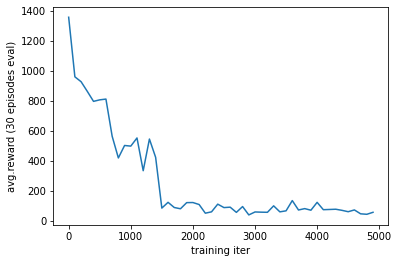

In [17]:
x = np.arange(0, training_iters, args.save_freq)
y = evaluations
plt.plot(x, y)
plt.ylabel('avg.reward (30 episodes eval)')
plt.xlabel('training iter')

## Evaluate

In [18]:
import os
import imageio
import numpy as np
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt    

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)

    drawer = ImageDraw.Draw(im)

    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

    return im


def save_agent_gif(env, random=False, fname='agent.gif', n_iter = 5):
    frames = []
    for i in range(n_iter):
        state = env.reset()        
        for t in range(500):
            
            if random:
                action = env.action_space.sample()
            else:
                action = best_policy.select_action(state)

            frame = env.render(mode='rgb_array')
            frames.append(_label_with_episode_number(frame, episode_num=i))

            state, _, done, _ = env.step(action)
            if done:
                break

    env.close()
    imageio.mimwrite(os.path.join(folder_name, fname), frames, fps=30)

### Random Agent

In [19]:
#Eval
evaluations = []
info = eval_policy(best_policy, env, random=True)
evaluations.append(info['AverageReturn'])

---------------------------------------
Evaluation over 30 episodes: 16.221
---------------------------------------


In [20]:
env = gym.make('bullet-walker2d-medium-v0')
save_agent_gif(env, random=True, fname='random.gif', n_iter=5)

### Exactly the same environment parameters

In [21]:
#Eval
evaluations = []
info = eval_policy(best_policy, env)
evaluations.append(info['AverageReturn'])
np.save(os.path.join(folder_name, 'eval'), evaluations)

---------------------------------------
Evaluation over 30 episodes: 1159.039
---------------------------------------


In [24]:
env = gym.make('bullet-walker2d-medium-v0')
save_agent_gif(env, fname='agent1.gif', n_iter=2)

### Tweaked environment parameters

In [23]:
# change environment parameters